In [1]:
from collections import defaultdict
from itertools import permutations
import math
import os

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from transformers import *

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU Available: True
Number of GPU Available: 4
GPU: Tesla V100-SXM2-32GB


In [3]:
df_full = pd.read_pickle("../data/fd_vn_physical_with_tokens_and_pooled_output_v5.pkl")

In [4]:
df_full.head()

,cc,sentence,syntax,fd,verb
0,"[{'text': 'cart', 'q_value': 'INTL', 'index': ...",The grocery cart hit against the wall,Sbj V PathP,Physical Force,hit
1,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",That type of rope coiled easily around the post,Sbj V PathP,Autonomous Place,coil
2,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",The rope coiled around the post,Sbj V PathP,Autonomous Place,coil
3,"[{'text': 'company', 'q_value': '+MER', 'index...",The company is wedging into new markets,Sbj V PathP,Autonomous Place,wedge
4,"[{'text': 'computer', 'q_value': '+MER', 'inde...",The computer connected well to the network,Sbj V PathP,Autonomous Place,connect


In [5]:
len(df_full)

565

In [6]:
df_full.iloc[0].cc

[{'text': 'cart',
  'q_value': 'INTL',
  'index': 3,
  'fd_subsequent': 7,
  'fd_relation': 'FRC'},
 {'text': 'wall',
  'q_value': 'EXIST',
  'index': 7,
  'fd_subsequent': -1,
  'fd_relation': 'None'}]

In [7]:
df_test_full = pd.read_pickle("../data/propara_fd_relations_v4.pkl")
len(df_test_full)

912

In [8]:
df_test_full.iloc[0]

pk                                                        4.1
cc          [{'text': 'sediment', 'q_value': 'EXIST', 'ind...
sentence                          They are buried in sediment
syntax                                             Sbj V LocP
fd                                        Autonomous Location
domain                                       physical_passive
Name: 0, dtype: object

In [9]:
def add_to_train_from_test(df_full, df_test_full):
    fd_rels = ['CAUSE', 'INT']
    domains = ['_passive', '_imperative']
    num_to_add = 5
    
    # df_temp corresponds to FD-VN-Physical
    df_temp = df_full.copy(deep=True)
    
    # df_test_temp corresponds to ProPara dataset
    df_test_temp = df_test_full.copy(deep=True)
    
    for fd_rel_to_add in fd_rels:
        num_added = 0
        for idx, row in df_test_full.iterrows():
            cc = row.cc
            for item in cc:
                
                if item['fd_relation'] == fd_rel_to_add and num_added<num_to_add:
                    num_added+=1
                    df_temp.loc[len(df_temp)] = row
                    df_test_temp.drop(df_test_temp.index[idx], inplace=True)
                    
    for domain in domains:
        num_added = 0
        for idx, row in df_test_full.iterrows():
            if domain in row.domain and num_added<num_to_add:
                num_added+=1
                df_temp.loc[len(df_temp)] = row
                df_test_temp.drop(df_test_temp.index[idx], inplace=True)

    print(len(df_temp))
    print(len(df_test_temp))
    return df_temp, df_test_temp
    
df, df_test_next = add_to_train_from_test(df_full, df_test_full)

585
892


In [10]:
def remove_xpr_from_test(df_test):
    fd_to_exclude = ['XPR']
    df_test_temp = pd.DataFrame(columns=df_test_full.columns)
    
    for idx, row in df_test.iterrows():
        xpr_detected = False
        cc = row.cc
        for item in cc:
            if item['fd_relation'] in fd_to_exclude:
                xpr_detected = True
        if not xpr_detected:
            df_test_temp.loc[len(df_test_temp)] = row
                    
    return df_test_temp

df_test = remove_xpr_from_test(df_test_next) 

In [11]:
len(df_test)

891

In [12]:
for idx, row in df_test.iterrows():
    cc = row.cc
    for item in cc:
        if item['fd_relation']=='XPR':
            print(item)

In [13]:
def get_all_unique_fd_relations(df):
    all_fd_relations = []
    all_ccs = df.cc
    for cc in all_ccs:
        for token_bundle in cc:
            fd_relation = token_bundle["fd_relation"]
            if fd_relation not in all_fd_relations:
                all_fd_relations.append(fd_relation)
                
    return sorted(all_fd_relations)
    
    
all_fd_relations = get_all_unique_fd_relations(df)
all_fd_relations

['',
 'AFF',
 'ATT',
 'CAUSE',
 'FORM',
 'FRC',
 'INT',
 'INTL',
 'None',
 'PTH',
 'PTH-complex',
 'XPR']

In [14]:
def make_idx_to_token_bundle_dict(cc_arr):
    token_bundle_dct = {}
    for t in cc_arr:
        
        if "fd_subsequent" in t:
            fd_sub = t["fd_subsequent"]
        else:
            fd_sub = -1

        token_bundle_dct[t["index"]] =  token_dct = {"text": t["text"], 
                                            "fd_subsequent": fd_sub,
                                            "fd_relation": t["fd_relation"]}
    return token_bundle_dct


def get_all_key_permutations(keys):
    return list(permutations(keys,2))


def get_sentence_with_two_entities_and_relation(df):
    all_sentences_with_entities_and_relations_bundles = []
    all_ccs = df.cc
    all_sentences = df.sentence
    _fd = df.fd
    
    for cc, sent, fd in zip(all_ccs, all_sentences, _fd):
        
        if 'Experience' in fd:
            pass
        else:   
            token_bundle_dct = make_idx_to_token_bundle_dict(cc)
            #print(token_bundle_dct)

            keys = token_bundle_dct.keys()

            all_key_permutations = get_all_key_permutations(keys)
            #print(all_key_permutations)
            # e.g., [(3, 7), (7, 3)]

            for key_perm in all_key_permutations:

                token0 = token_bundle_dct[key_perm[0]]["text"]
                token1 = token_bundle_dct[key_perm[1]]["text"]

                if token_bundle_dct[key_perm[0]]["fd_subsequent"] == key_perm[1]:
                    fd_relation = all_fd_relations.index(token_bundle_dct[key_perm[0]]["fd_relation"])
                else:
                    fd_relation = all_fd_relations.index("None")

                # only one example of these for now
                if all_fd_relations[fd_relation] != 'CTR':

                    feature_arr = [sent, token0, token1, fd_relation]

                    all_sentences_with_entities_and_relations_bundles.append(feature_arr)
            
    return all_sentences_with_entities_and_relations_bundles
            
     
all_sentences_with_entities_and_relations_bundles = get_sentence_with_two_entities_and_relation(df) 

all_sentences_with_entities_and_relations_bundles[80:90]

[['Paula hit the stick against the fence', 'fence', 'Paula', 8],
 ['Paula hit the stick against the fence', 'fence', 'stick', 8],
 ['Smith inscribed his name on the ring', 'Smith', 'name', 5],
 ['Smith inscribed his name on the ring', 'Smith', 'ring', 8],
 ['Smith inscribed his name on the ring', 'name', 'Smith', 8],
 ['Smith inscribed his name on the ring', 'name', 'ring', 9],
 ['Smith inscribed his name on the ring', 'ring', 'Smith', 8],
 ['Smith inscribed his name on the ring', 'ring', 'name', 8],
 ['Herman added a computer to the network', 'Herman', 'computer', 5],
 ['Herman added a computer to the network', 'Herman', 'network', 8]]

In [15]:
len(all_sentences_with_entities_and_relations_bundles)

1672

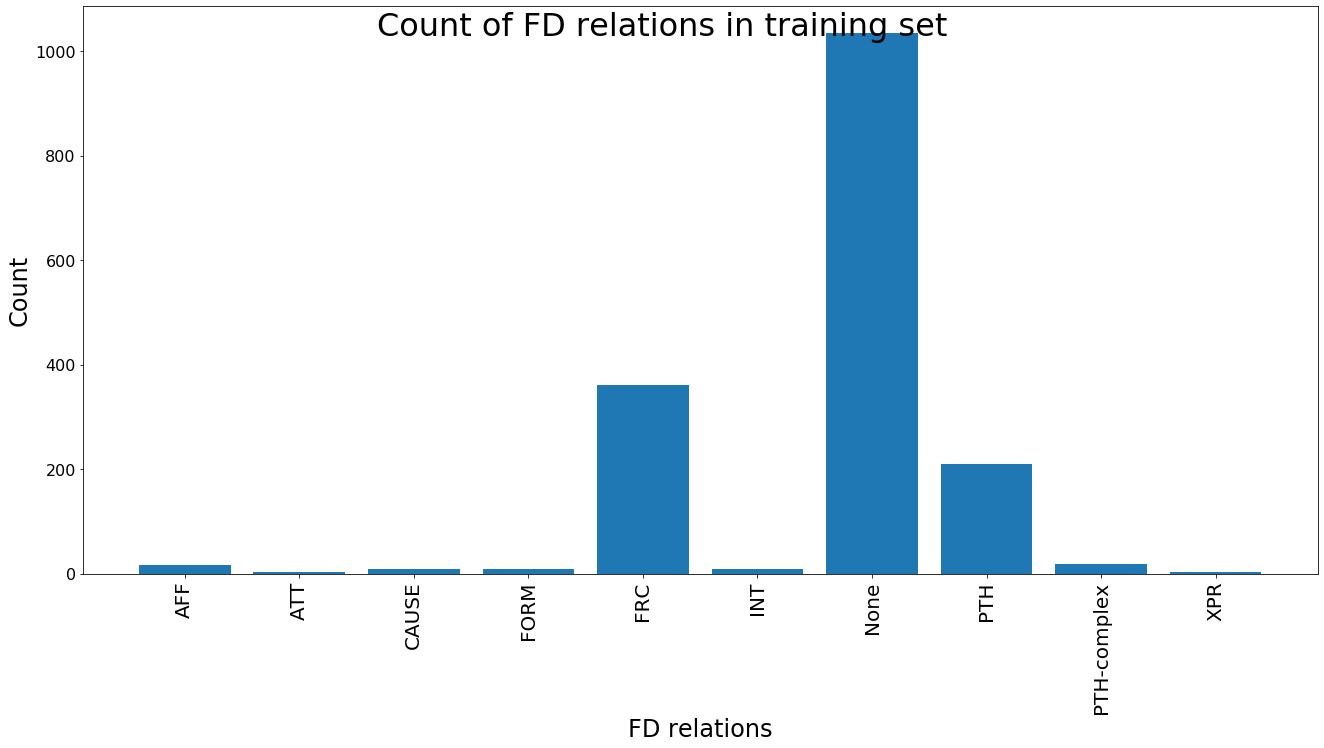

In [18]:

cnt_fd_relations = defaultdict(int)

for bundle in all_sentences_with_entities_and_relations_bundles:
    cnt_fd_relations[all_fd_relations[bundle[3]]] += 1
    
ordered_rel_keys, ordered_rel_values = zip(*sorted(zip(list(cnt_fd_relations.keys()), list(cnt_fd_relations.values()))))
 
fig = plt.figure()
plt.bar(range(len(cnt_fd_relations)), ordered_rel_values, align='center')
plt.xticks(range(len(cnt_fd_relations)), ordered_rel_keys, rotation=90, fontsize=20)
plt.yticks(fontsize=16)

fig.set_size_inches(18.5, 10.5)
fig.suptitle('Count of FD relations in training set', fontsize=32)
plt.xlabel('FD relations', fontsize=24)
plt.ylabel('Count', fontsize=24)
#plt.show()
plt.tight_layout()
fig.savefig('/nfs/research/regan/viz/rq12-count-fd-relations.eps', format='eps')

In [17]:
for rel_key, rel_val in zip(ordered_rel_keys, ordered_rel_values):
    print(rel_key, rel_val)

AFF 17
ATT 4
CAUSE 9
FORM 8
FRC 361
INT 8
None 1034
PTH 209
PTH-complex 19
XPR 3


In [18]:
pos_weight_ = [[1176/ordered_rel_values[idx], ordered_rel_keys[idx]] for idx,_ in enumerate(ordered_rel_keys)]
pos_weight_

[[69.17647058823529, 'AFF'],
 [294.0, 'ATT'],
 [130.66666666666666, 'CAUSE'],
 [147.0, 'FORM'],
 [3.257617728531856, 'FRC'],
 [147.0, 'INT'],
 [1.137330754352031, 'None'],
 [5.626794258373206, 'PTH'],
 [61.89473684210526, 'PTH-complex'],
 [392.0, 'XPR']]

In [19]:
#pos_weight = torch.tensor([i[0] for i in pos_weight_]).to(device)
pos_weight = torch.tensor([2.0,3.0,3.0,3.0,1.0,3.0,1.0,1.0,2.0,3.0]).to(device)
pos_weight

tensor([2., 3., 3., 3., 1., 3., 1., 1., 2., 3.], device='cuda:0')

In [20]:
def get_roberta_sentences_and_labels(all_sent_bundles):
    
    sentences = ["<s> " + (f[0] + " </s> </s> " + f[1] + " " + f[2] + " </s>") for f in all_sent_bundles]
    
    labels = [f[3] for f in all_sent_bundles]
    
    return sentences, labels

sentences, labels = get_roberta_sentences_and_labels(all_sentences_with_entities_and_relations_bundles)

print(sentences[0])

print(labels[0])

<s> The grocery cart hit against the wall </s> </s> cart wall </s>
5


In [21]:
pretrained_weights = 'roberta-large'

tokenizer = RobertaTokenizer.from_pretrained(pretrained_weights, do_lower_case=False)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts[0]

['<s>',
 'ĠThe',
 'Ġgrocery',
 'Ġcart',
 'Ġhit',
 'Ġagainst',
 'Ġthe',
 'Ġwall',
 'Ġ',
 '</s>',
 'Ġ',
 '</s>',
 'Ġcart',
 'Ġwall',
 'Ġ',
 '</s>']

In [22]:
max_length = 32

# Use the Roberta tokenizer to convert the tokens to their index numbers in the Roberta vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

encodings = tokenizer.batch_encode_plus(sentences,max_length=max_length,pad_to_max_length=True,return_token_type_ids=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [23]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [24]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=216, test_size=0.40, stratify = labels)

In [25]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [26]:
# Select a batch size for training.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [27]:
num_labels = len(all_fd_relations)

model = RobertaForSequenceClassification.from_pretrained(pretrained_weights, num_labels=num_labels)

model.cuda()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [28]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [29]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

# Number of training epochs (authors recommend between 2 and 4)
epochs = 16

num_warmup_steps = batch_size
num_total_steps = batch_size * epochs

#scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_total_steps)  # PyTorch scheduler


In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
# Store our loss and accuracy for plotting
train_loss_set = []


# Tracking predictions and labels for confusion matrix
y_pred = []
y_true = []

# trange is a tqdm wrapper around the normal python range
for epoch in trange(epochs, desc="Epoch"):
    
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#     loss = outputs[0]
#     logits = outputs[1]

    logits = outputs[1]
        
    #loss_func = CrossEntropyLoss(weight=pos_weight) 
    loss_func = CrossEntropyLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.long().view(-1)) #convert labels to long for calculation
    
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    #scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    
    if epoch == epochs-1:
        y_pred.extend(np.argmax(logits, axis=1).flatten())
        y_true.extend(label_ids.flatten())

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/16 [00:00<?, ?it/s]

Train loss: 1.356621578335762


Epoch:   6%|▋         | 1/16 [00:08<02:03,  8.24s/it]

Validation Accuracy: 0.6186884236453202
Train loss: 1.0692277140915394


Epoch:  12%|█▎        | 2/16 [00:16<01:54,  8.19s/it]

Validation Accuracy: 0.6337233169129721
Train loss: 0.7018759762868285


Epoch:  19%|█▉        | 3/16 [00:24<01:46,  8.16s/it]

Validation Accuracy: 0.7955151888341544
Train loss: 0.4537373576313257


Epoch:  25%|██▌       | 4/16 [00:32<01:37,  8.14s/it]

Validation Accuracy: 0.8418000821018063
Train loss: 0.28699378366582096


Epoch:  31%|███▏      | 5/16 [00:40<01:29,  8.14s/it]

Validation Accuracy: 0.894037356321839
Train loss: 0.18772797798737884


Epoch:  38%|███▊      | 6/16 [00:48<01:21,  8.14s/it]

Validation Accuracy: 0.8955254515599342
Train loss: 0.1674008732661605


Epoch:  44%|████▍     | 7/16 [00:56<01:13,  8.14s/it]

Validation Accuracy: 0.9165127257799671
Train loss: 0.1335065397724975


Epoch:  50%|█████     | 8/16 [01:05<01:05,  8.15s/it]

Validation Accuracy: 0.9315476190476191
Train loss: 0.09309781623596791


Epoch:  56%|█████▋    | 9/16 [01:13<00:57,  8.16s/it]

Validation Accuracy: 0.9342159277504104
Train loss: 0.06883846537675709


Epoch:  62%|██████▎   | 10/16 [01:21<00:48,  8.17s/it]

Validation Accuracy: 0.9434523809523809
Train loss: 0.047671210777480155


Epoch:  69%|██████▉   | 11/16 [01:29<00:40,  8.17s/it]

Validation Accuracy: 0.9358579638752053
Train loss: 0.09177064936375245


Epoch:  75%|███████▌  | 12/16 [01:37<00:32,  8.17s/it]

Validation Accuracy: 0.9386802134646961
Train loss: 0.056764126842608675


Epoch:  81%|████████▏ | 13/16 [01:45<00:24,  8.18s/it]

Validation Accuracy: 0.953715106732348
Train loss: 0.037581452808808535


Epoch:  88%|████████▊ | 14/16 [01:54<00:16,  8.18s/it]

Validation Accuracy: 0.953715106732348
Train loss: 0.014544147386914119


Epoch:  94%|█████████▍| 15/16 [02:02<00:08,  8.18s/it]

Validation Accuracy: 0.9566912972085385
Train loss: 0.0077017463991069235


Epoch: 100%|██████████| 16/16 [02:10<00:00,  8.16s/it]

Validation Accuracy: 0.9583333333333334


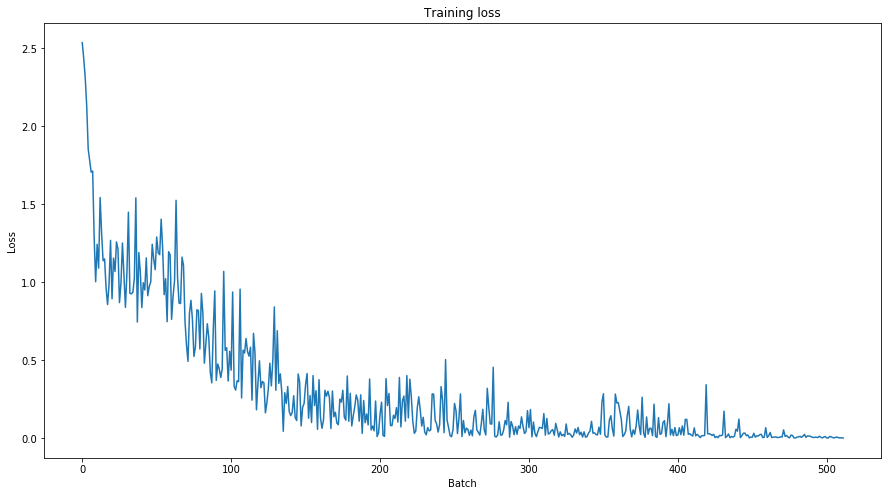

In [32]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [33]:
all_fd_relations_for_valid = [all_fd_relations[idx] for idx in set(y_true)]
all_fd_relations_for_valid

['AFF',
 'ATT',
 'CAUSE',
 'FORM',
 'FRC',
 'INT',
 'None',
 'PTH',
 'PTH-complex',
 'XPR']

In [34]:
c_matrix = confusion_matrix(y_true, y_pred)
c_matrix

array([[  7,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   3,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   3,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 139,   0,   4,   1,   0,   0],
       [  0,   0,   0,   0,   0,   3,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0, 406,   3,   3,   0],
       [  1,   0,   0,   0,  10,   0,   2,  71,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   7,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1]])

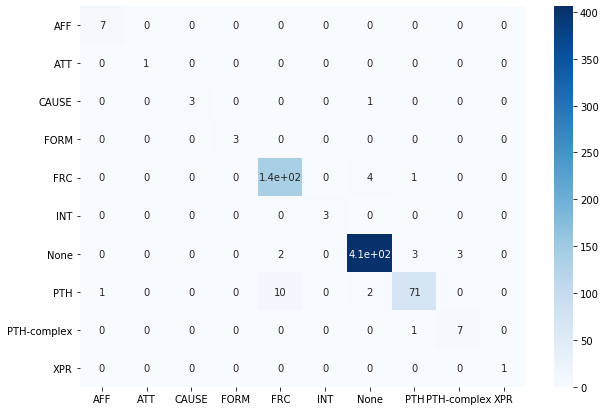

In [35]:
def plot_confusion_matrix(c_matrix, fd_rels):
    df_cm = pd.DataFrame(c_matrix, index = [i for i in fd_rels],
                  columns = [i for i in fd_rels])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)    

    
plot_confusion_matrix(c_matrix, all_fd_relations_for_valid)

In [36]:
df_test.head()

,pk,cc,sentence,syntax,fd,domain
0,4.2,"[{'text': 'sediment', 'q_value': 'EXIST', 'ind...",Bacteria is buried in sediment,Sbj V LocP,Autonomous Location,physical_passive
1,5.1,"[{'text': 'algae', 'q_value': 'COS', 'index': ...",dead algae and plankton end up part of sedimen...,Sbj V Obj,Autonomous COS,physical
2,5.3,"[{'text': 'pressure', 'q_value': 'INTL', 'inde...",bottom layers of sediment become compacted by ...,Sbj V Obj,Physical COS,physical
3,5.4,"[{'text': 'sediment', 'q_value': 'COS', 'index...",Higher pressure causes sediment to heat up,Sbj V Comp,Physical COS,physical
4,5.5,"[{'text': 'processes', 'q_value': 'INTL', 'ind...",heat causes chemical processes,Sbj V Obj,Physical Internal,physical


In [37]:
len(df_test)

891

In [38]:
all_fd_relations

['',
 'AFF',
 'ATT',
 'CAUSE',
 'FORM',
 'FRC',
 'INT',
 'INTL',
 'None',
 'PTH',
 'PTH-complex',
 'XPR']

In [39]:
all_test_sentences_with_entities_and_relations_bundles = get_sentence_with_two_entities_and_relation(df_test) 

all_test_sentences_with_entities_and_relations_bundles[0:20]

[['Bacteria is buried in sediment', 'sediment', 'Bacteria', 8],
 ['Bacteria is buried in sediment', 'Bacteria', 'sediment', 9],
 ['dead algae and plankton end up part of sediment on seafloor',
  'algae',
  'sediment',
  8],
 ['dead algae and plankton end up part of sediment on seafloor',
  'algae',
  'seafloor',
  8],
 ['dead algae and plankton end up part of sediment on seafloor',
  'sediment',
  'algae',
  8],
 ['dead algae and plankton end up part of sediment on seafloor',
  'sediment',
  'seafloor',
  8],
 ['dead algae and plankton end up part of sediment on seafloor',
  'seafloor',
  'algae',
  8],
 ['dead algae and plankton end up part of sediment on seafloor',
  'seafloor',
  'sediment',
  8],
 ['bottom layers of sediment become compacted by pressure',
  'pressure',
  'layers',
  5],
 ['bottom layers of sediment become compacted by pressure',
  'layers',
  'pressure',
  8],
 ['Higher pressure causes sediment to heat up', 'sediment', 'pressure', 8],
 ['Higher pressure causes sedi

In [40]:
len(all_test_sentences_with_entities_and_relations_bundles)

2530

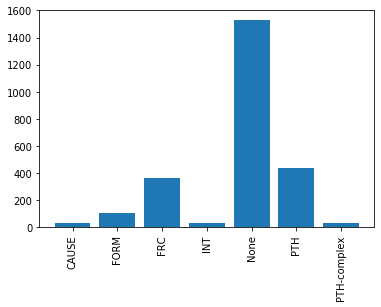

In [41]:
cnt_test_fd_relations = defaultdict(int)

for bundle in all_test_sentences_with_entities_and_relations_bundles:
    cnt_test_fd_relations[all_fd_relations[bundle[3]]] += 1

ordered_rel_keys_test, ordered_rel_values_test = zip(*sorted(zip(list(cnt_test_fd_relations.keys()), list(cnt_test_fd_relations.values()))))

plt.bar(range(len(cnt_test_fd_relations)), ordered_rel_values_test, align='center')
plt.xticks(range(len(cnt_test_fd_relations)), ordered_rel_keys_test, rotation=90)
plt.show()

In [42]:
for rel_key, rel_val in zip(ordered_rel_keys_test, ordered_rel_values_test):
    print(rel_key, rel_val)

CAUSE 29
FORM 105
FRC 362
INT 33
None 1527
PTH 440
PTH-complex 34


In [43]:
test_sents, test_labels = get_roberta_sentences_and_labels(all_test_sentences_with_entities_and_relations_bundles)
print(test_sents[0])
print(test_labels[0])

<s> Bacteria is buried in sediment </s> </s> sediment Bacteria </s>
8


In [44]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sents]
test_tokenized_texts[0]

['<s>',
 'ĠB',
 'acteria',
 'Ġis',
 'Ġburied',
 'Ġin',
 'Ġsediment',
 'Ġ',
 '</s>',
 'Ġ',
 '</s>',
 'Ġsediment',
 'ĠB',
 'acteria',
 'Ġ',
 '</s>']

In [45]:
max_length = 32

# Use the Roberta tokenizer to convert the tokens to their index numbers in the Roberta vocabulary
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]

test_encodings = tokenizer.batch_encode_plus(test_sents,max_length=max_length,pad_to_max_length=True,return_token_type_ids=True) # tokenizer's encoding method
print('tokenizer outputs: ', test_encodings.keys())

/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [46]:
test_input_ids = test_encodings['input_ids'] # tokenized and encoded sentences
test_token_type_ids = test_encodings['token_type_ids'] # token type ids
test_attention_masks = test_encodings['attention_mask'] # attention masks

In [47]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
# torch.save(test_dataloader,'test_data_loader')

In [48]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Flatten outputs
#test_tokenized_texts = [item for sublist in test_tokenized_texts for item in sublist]
test_pred_labels = [np.argmax(item) for sublist in predictions for item in sublist]
test_true_labels = [item for sublist in true_labels for item in sublist]

In [49]:
print(test_true_labels[0], test_pred_labels[0])
print(test_true_labels[1], test_pred_labels[1])

8 8
9 9


In [50]:
print(set(test_true_labels))
print(set(test_pred_labels))

{3, 4, 5, 6, 8, 9, 10}
{2, 3, 4, 5, 6, 8, 9, 10}


In [51]:
all_fd_relations

['',
 'AFF',
 'ATT',
 'CAUSE',
 'FORM',
 'FRC',
 'INT',
 'INTL',
 'None',
 'PTH',
 'PTH-complex',
 'XPR']

In [52]:
test_c_matrix = confusion_matrix(test_true_labels, test_pred_labels)
test_c_matrix

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,   15,    0,    8,    0,    6,    0,    0],
       [   0,    6,   63,    6,    0,   17,   13,    0],
       [   1,   56,    1,  212,    0,   70,   22,    0],
       [   0,    1,    0,    0,   18,   11,    3,    0],
       [   0,   10,   11,   37,    1, 1366,   98,    4],
       [   0,    1,    0,   12,    0,   24,  402,    1],
       [   0,    0,    0,    0,    0,   10,    4,   20]])

In [53]:
# test_c_matrix = np.delete(test_c_matrix_1, -1, 0)
# test_c_matrix = np.delete(test_c_matrix, -1, 1)
# test_c_matrix

In [54]:
all_fd_relations_for_test = [all_fd_relations[idx] for idx in set(test_true_labels).union(set(test_pred_labels))]
all_fd_relations_for_test

['ATT', 'CAUSE', 'FORM', 'FRC', 'INT', 'None', 'PTH', 'PTH-complex']

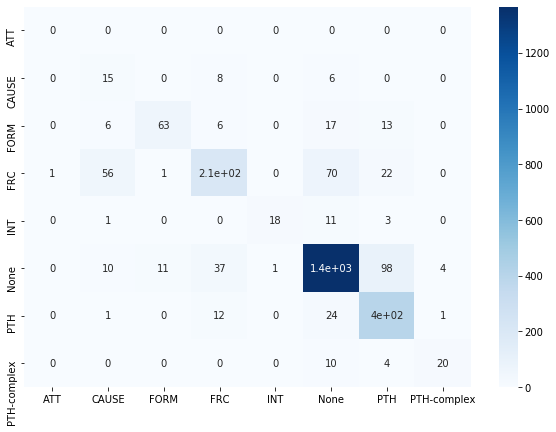

In [55]:
plot_confusion_matrix(test_c_matrix, all_fd_relations_for_test)

In [56]:
# Print and save classification report
print('Test F1 Accuracy: ', f1_score(test_true_labels, test_pred_labels,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(test_true_labels, test_pred_labels),'\n')
clf_report = classification_report(test_true_labels,
                                   test_pred_labels,
                                   target_names=all_fd_relations_for_test, 
                                   labels=None)
#pickle.dump(clf_report, open('../reports/classification_report_16_epochs_alltest.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.8284584980237153
Test Flat Accuracy:  0.8284584980237154 

              precision    recall  f1-score   support

         ATT       0.00      0.00      0.00         0
       CAUSE       0.17      0.52      0.25        29
        FORM       0.84      0.60      0.70       105
         FRC       0.77      0.59      0.67       362
         INT       0.95      0.55      0.69        33
        None       0.91      0.89      0.90      1527
         PTH       0.74      0.91      0.82       440
 PTH-complex       0.80      0.59      0.68        34

    accuracy                           0.83      2530
   macro avg       0.65      0.58      0.59      2530
weighted avg       0.85      0.83      0.83      2530



/nfs/research/regan/.conda/envs/torch-roberta/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
probs = [item for sublist in predictions for item in sublist]

preds_for_df = [(s[0], s[1], s[2], all_fd_relations[true], all_fd_relations[pred], l[0], l[1], l[2], l[3], l[4], l[5], l[6], l[7], l[8], l[9]) 
                for (s, true, pred, l) 
                in zip(all_test_sentences_with_entities_and_relations_bundles[:20], test_true_labels[:20], test_pred_labels[:20], probs[:20])]

pred_columns = ['sentence', 'e1', 'e2', 'true_y', 'pred_y'] + all_fd_relations

df_preds = pd.DataFrame(preds_for_df, columns=pred_columns)



ValueError: 17 columns passed, passed data had 15 columns

In [ ]:
df_preds

In [ ]:
df_preds.iloc[0]['sentence']